# Good Wine Predictions

##### github link: https://github.com/arthurdiercu/CSCA_5622_Final

### The Problem:
For this project, the goal is to predict the quality of wine based on it physicochemical characteristics using supervised learning methods.
The dataset I have chosen contains two sources:

    • Red Wine quality data
    • White Wine quality data

Each wine sample includes 11 numeric chemical features (acidity, alcohol, ph) and a quality score that ranges from 0 to 10.
Since predicting the exact numeric value for quality would be more difficult due to imbalance and sparsity, I converted it into a binary classification problem:

    • Good Wine (label = 1) if quality >= 7
    • Bad/Average wine (label = 0) if quality < 7

The Goal is to identify wines of good quality based on the chemical tests, improving consumer choices or production quality assessment.
The wine quality prediction is important to streamline quality control in wine production and help the consumer make informed choices.

##### Data Source and Description:

The dataset comes from a Hugging Face repository, consisting of a Red Wine and White Wine quality dataset. 

https://huggingface.co/datasets/codesignal/wine-quality/blob/main/winequality-red.csv

https://huggingface.co/datasets/codesignal/wine-quality/blob/main/winequality-white.csv

The datasets are tabular and consists of roughly 6500 samples (a combination of Red and White wines).

There are 12 features: 11 are physicochemical measurements and the other 1 is the quality score.

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay


### Data Cleaning
I recognized that the provided CSVs were semicolon-separated and quoted improperly.
I loaded the data and split the column names properly and converted all features to numeric.
There were no missing values found, besides the way of storing the data, it seemed clean.

A new column was created for the binary classification, called 'good_wine'.

Overall the dataset only required formatting corrections.

In [301]:
# Load the datasets
red_wine = pd.read_csv("winequality-red.csv", sep=';', quotechar='"')
white_wine = pd.read_csv("winequality-white.csv", sep=';', quotechar='"')

In [302]:
# Show the first rows of the datasets
print("Red Wine Dataset:")
print(red_wine.head())
print("White Wine Dataset:")
print(white_wine.head())


Red Wine Dataset:
                                                         "fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7.4  0.70 0.00 1.9 0.076 11.0 34.0 0.9978 3.51 0.56 9.4                                                  5                                                                                                                        
7.8  0.88 0.00 2.6 0.098 25.0 67.0 0.9968 3.20 0.68 9.8                                                  5                                                                                                                        
     0.76 0.04 2.3 0.092 15.0 54.0 0.9970 3.26 0.65 9.8                                                  5                                                                                                                        
11.2 0.28 0.56 1.9 0.075 17.0 60.0 0.9980 3.16 0.58 9.8                   

In [303]:
# Clean up the Red Wine quality csv.

red_df = pd.read_csv('winequality-red.csv', header=None)

column_names = red_df.iloc[0, 0].split(';')

red_data = red_df.iloc[1:, 0].str.split(';', expand=True)

red_data.columns = [col.strip('"') for col in column_names]

red_data = red_data.apply(pd.to_numeric)

red_data = red_data.reset_index(drop=True)

print(red_data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [304]:
# Clean up the Red Wine quality csv.

white_df = pd.read_csv('winequality-white.csv', header=None)

column_names = white_df.iloc[0, 0].split(';')

white_data = white_df.iloc[1:, 0].str.split(';', expand=True)

white_data.columns = [col.strip('"') for col in column_names]

white_data = white_data.apply(pd.to_numeric)

white_data = white_data.reset_index(drop=True)

print(white_data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6 

In [305]:
# Save the cleaned datasets
red_data.to_csv('cleaned_winequality-red.csv', index=False)
white_data.to_csv('cleaned_winequality-white.csv', index=False)

### Exploratory Data Analysis (EDA)

#### Data Inspection
    • After cleaning the data, the total number of wines between the red and white wine datasets is 6497 samples.
    • These samples include features like acidity levels, chlorides, alcohol percentage, etc.
    • I plotted distributions of wine quality scores and feature distributions. Also a correlation matrix (heatmap).
##### Distribution of Wine Quality
    • Most of the wines had a quality score or 5, 6 or 7.
    • There were very few samples with scores of 3, 4, 8, and 9.
    • Note that there were no scores below 3 and none of the wines had a 10 rating.
    • Alcohol is moderately positively correlated with the wine quality (+0.44)
    • Volatile acidity is newgatively correlated with quality (-0.39)
    • Some feature skewness was present. (sulphates, sugar)

The EDA revealed that few features may strongly impact the wine predictions, especially alcohol content.

In [306]:
# Combine the red and white data
wine_df = pd.concat([red_data, white_data], axis=0, ignore_index=True)

print(wine_df.head())
print("Combined Shape:", wine_df.shape)

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [307]:
# Basic Information
print("Data Information:")
print(wine_df.info())

print("\nStatistical Summary:")
print(wine_df.describe())

print("\nFirst 5 Rows:")
print(wine_df.head())

Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB
None

Statistical Summary:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6

## Distribution of Wine Qaulity Scores

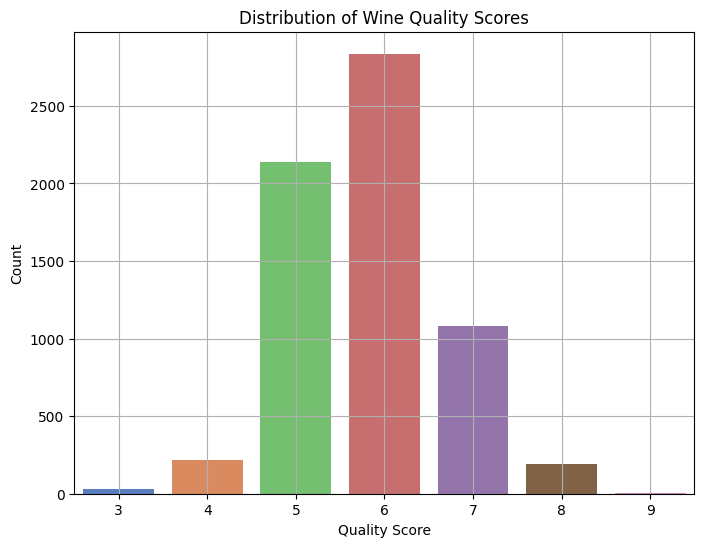

In [308]:
plt.figure(figsize=(8,6))
sns.countplot(x='quality', hue='quality', data=wine_df, palette='muted', legend=False)
plt.title('Distribution of Wine Quality Scores')
plt.xlabel('Quality Score')
plt.ylabel('Count')
plt.grid(True)
plt.show()

Distribution of Qaulity: Most of the wines have a quality score of 5-7. Few qualities are at 3, 4, 8, 9.

Feature Distributions: Many features like residual sugar, sulphates, total sulfur dioxide are skewed.

## Feature Distributions

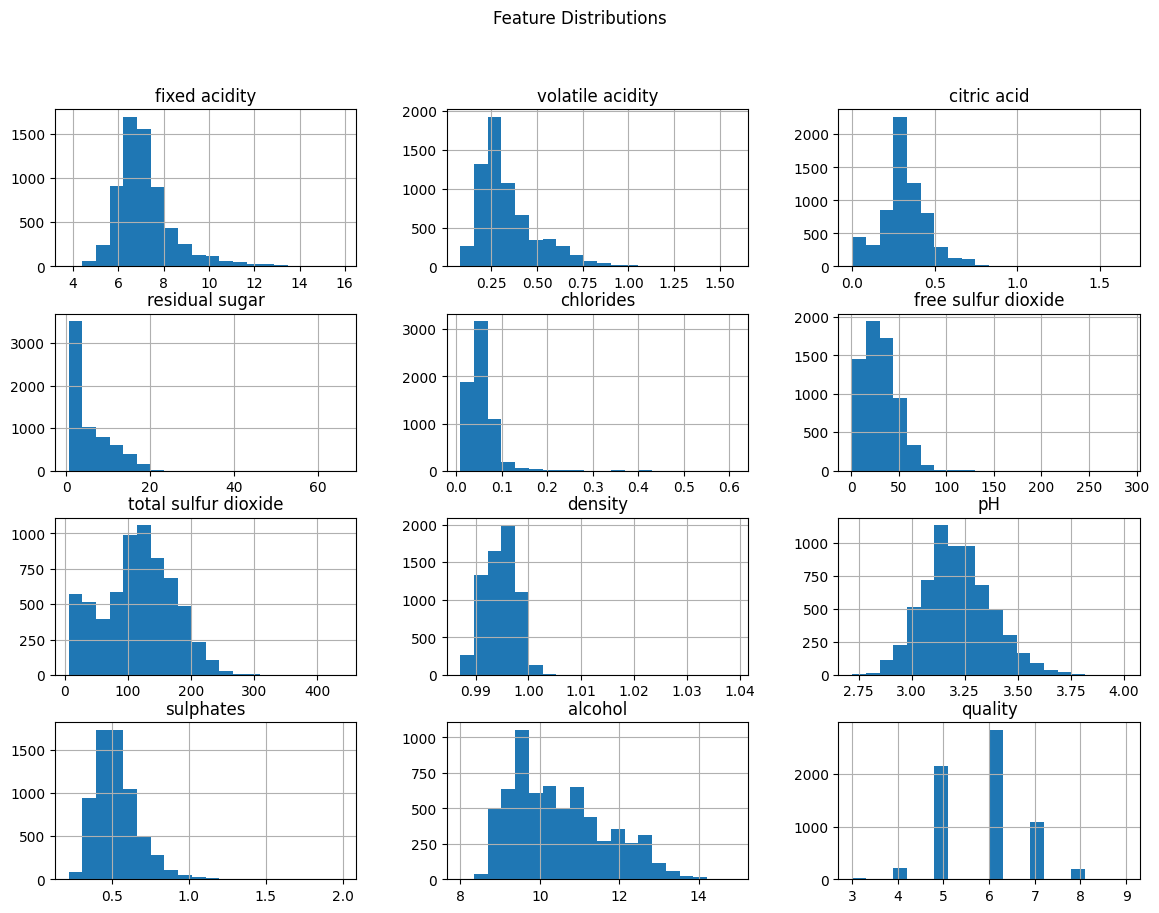

In [309]:
wine_df.hist(figsize=(14,10), bins=20)
plt.suptitle('Feature Distributions')
plt.show()

## Correlation Matrix of Wine Features
Correlation Insights: Alcohol shows a positive correlation with wine quality. Density and volatile
acidicty have a negative correlation with quality.

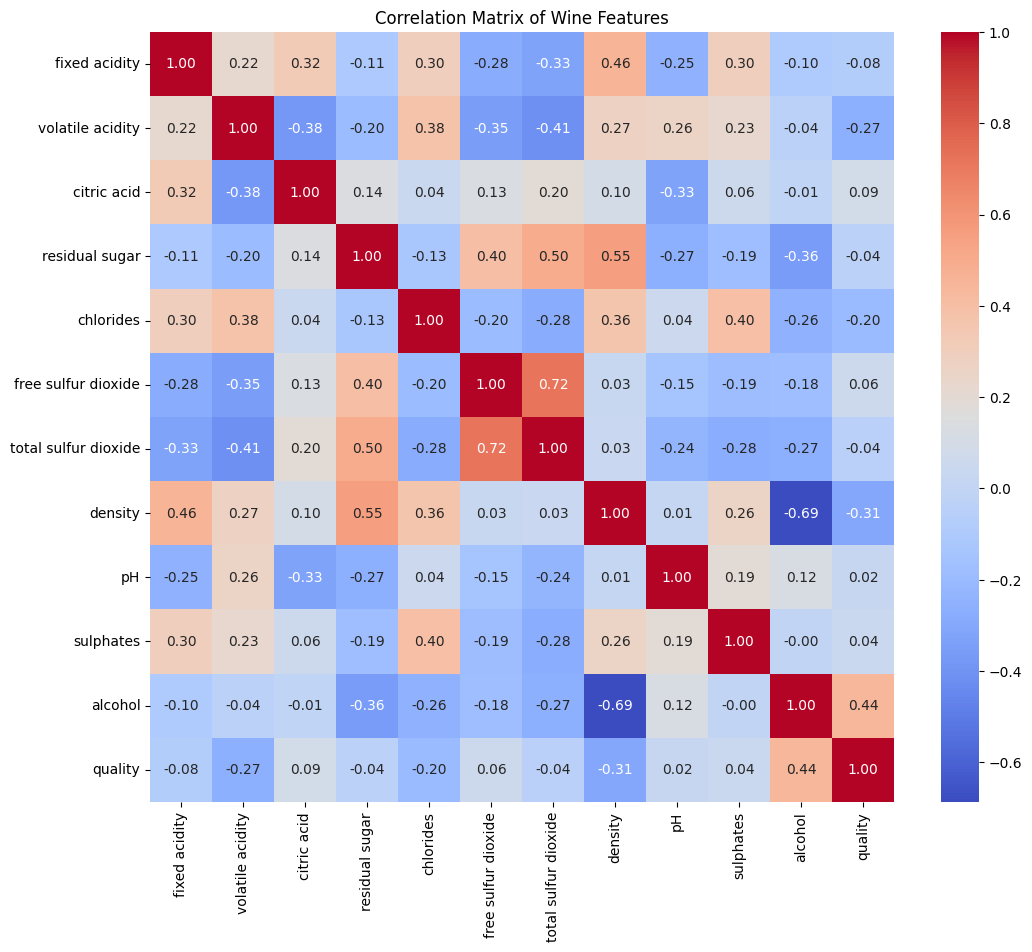

In [310]:
plt.figure(figsize=(12,10))
corr = wine_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Wine Features')
plt.show()

Here I created the 'good_wine' binary target variable.

I then dropped the following columns from our wine dataframe:

    • quality
    • good_wine

In [311]:
# Create binary target variable: good_wine
# 1 if quality > 7, else 0
wine_df['good_wine'] = wine_df['quality'].apply(lambda x: 1 if x >= 7 else 0)

print('Good Wine Label Distribution:')
print(wine_df['good_wine'].value_counts())

Good Wine Label Distribution:
good_wine
0    5220
1    1277
Name: count, dtype: int64


In [312]:
X = wine_df.drop(columns=['quality','good_wine'])
y = wine_df['good_wine']

### Model Building and Training

    • I used a Logistic Regression model and then a Random Forest Classifier.
    • The data was split 80% to train and 20% to test.
    • A StandardScaler was used on both the Regression and Random Forest.

In [313]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=55, stratify=y
)

In [314]:
print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (5197, 11)
Testing Set Shape: (1300, 11)


In [315]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [316]:
print(wine_df['good_wine'].value_counts())


good_wine
0    5220
1    1277
Name: count, dtype: int64


#### Logistic Regression
Had an accuracy of 81.6%, the precision for Good Wines was only 58% though.

In [317]:
# Initialize Model
log_reg = LogisticRegression(max_iter=1000, random_state=55)

# Train Model
log_reg.fit(X_train_scaled, y_train)

# Predict
log_reg_preds = log_reg.predict(X_test_scaled)

print("--- Logistic Regression ---")
print("Accuracy:", accuracy_score(y_test, log_reg_preds))
print("Classification Report:\n", classification_report(y_test, log_reg_preds))
print("Confussion Matrix:\n", confusion_matrix(y_test, log_reg_preds))

--- Logistic Regression ---
Accuracy: 0.8161538461538461
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89      1044
           1       0.58      0.25      0.35       256

    accuracy                           0.82      1300
   macro avg       0.71      0.60      0.62      1300
weighted avg       0.79      0.82      0.79      1300

Confussion Matrix:
 [[998  46]
 [193  63]]


<Figure size 600x500 with 0 Axes>

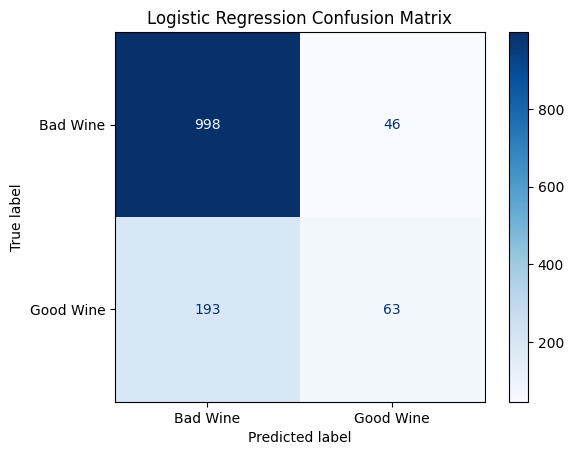

In [318]:
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, log_reg_preds, cmap='Blues', display_labels=['Bad Wine','Good Wine'])
plt.title('Logistic Regression Confusion Matrix')
plt.grid(False)
plt.show()

#### Random Forest
Had an accuracy of 88.4%, the precision for Good Wines was 82%, which is a great improvement compared to the Logistic Regression model.

In [319]:
# Initialize Model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=55)

# Train Model
rf_clf.fit(X_train_scaled, y_train)

# Predict
rf_preds = rf_clf.predict(X_test_scaled)

print("\n--- Random Forest Classifier ---")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Classification Report:\n", classification_report(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))


--- Random Forest Classifier ---
Accuracy: 0.8838461538461538
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.97      0.93      1044
           1       0.82      0.53      0.64       256

    accuracy                           0.88      1300
   macro avg       0.86      0.75      0.79      1300
weighted avg       0.88      0.88      0.87      1300

Confusion Matrix:
 [[1014   30]
 [ 121  135]]


<Figure size 600x500 with 0 Axes>

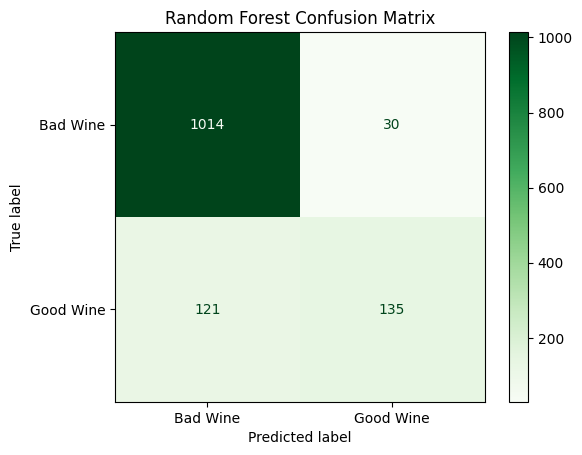

In [320]:
plt.figure(figsize=(6,5))
ConfusionMatrixDisplay.from_predictions(y_test, rf_preds, cmap="Greens", display_labels=['Bad Wine', 'Good Wine'])
plt.title('Random Forest Confusion Matrix')
plt.grid(False)
plt.show()

#### Conclusion
The Random Forest performed much better for this dataset. The Logistic Regression seemed to underperform due to difficulty in separating classes linearly.
Future improvements could involve oversampling methods or using a boosting algorithms as well. 

In the end, Random Forest was selected as the final model due to its better balance between precision and recall, especially for detecting good wines, which was the overall goal.